<a href="https://colab.research.google.com/github/lucyvost/dtc_docking/blob/main/DTC_smolecules_day_2_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running anything:
 - select Runtime -> Change runtime type -> GPU
 - upload the file `requirements.txt`

Then, whilst you get cosy, run the below cell to get conda and the various packages we'll be using installed

You'll get a message about your kernel unexpectedly crashing - don't worry, that's just the restart that needs to happen for condacolab to work


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
#@title Install dependencies (this will take about 5 minutes)
%%capture
%cd /content

import os
! pip install -r requirements.txt
commands = [
    "conda install openbabel -c conda-forge",
    "git clone https://github.com/arneschneuing/DiffSBDD.git",
    "mkdir -p /content/DiffSBDD/checkpoints",
    "wget -P /content/DiffSBDD/checkpoints https://zenodo.org/record/8183747/files/moad_fullatom_cond.ckpt",
    "wget -P /content/DiffSBDD/checkpoints https://zenodo.org/record/8183747/files/moad_fullatom_joint.ckpt",
]

errors = {}

if not os.path.isfile("/content/READY"):
  for cmd in commands:
    # os.system(cmd)
    with os.popen(cmd) as f:
      out = f.read()
      status = f.close()

    if status is not None:
      errors[cmd] = out
      print(f"\n\nAn error occurred while running '{cmd}'\n")
      print("Status:\t", status)
      print("Message:\t", out)

if len(errors) == 0:
  os.system("touch /content/READY")


! pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

## PART 1: molecule generation

### *de novo* molecule generation with DiffSBDD

First we're going to look at pocket-conditioned *de novo* compound generation with DiffSBDD: Structure-based Drug Design with Equivariant Diffusion Models.

[**[Paper]**](https://arxiv.org/abs/2210.13695)
[**[Code]**](https://github.com/arneschneuing/DiffSBDD)


<img src="https://raw.githubusercontent.com/arneschneuing/DiffSBDD/main/img/overview.png" height=250>

Download your target PDB: we're going to be looking at 3RFM

In [2]:
from google.colab import files
from google.colab import output
output.enable_custom_widget_manager()
import os.path
from pathlib import Path
import urllib
import os

input_dir = Path("/content/input_pdbs/")
output_dir = Path("/content/output_sdfs/")
input_dir.mkdir(exist_ok=True)
output_dir.mkdir(exist_ok=True)


pdbfile = Path(input_dir, '3rfm.pdb')
urllib.request.urlretrieve('http://files.rcsb.org/download/3rfm.pdb', pdbfile)



(PosixPath('/content/input_pdbs/3rfm.pdb'),
 <http.client.HTTPMessage at 0x7f86efda8580>)

Define binding pocket
You can choose between two options to define the binding pocket:

list of residues: provide a list where each residue is specified as <chain_id>:<res_id>, e.g, A:1 A:2 A:3 A:4 A:5 A:6 A:7
reference ligand: if the uploaded PDB structure contains a reference ligand in the target pocket, you can specify its location as <chain_id>:<res_id> and the pocket will be extracted automatically

In [3]:
#@title { run: "auto" }
import ipywidgets as widgets

#@markdown **Note:** This cell is an interactive widget and the values will be updated automatically every time you change them. You do not need to execute the cell again. If you do, the default values will be reinserted.

pocket_definition = "reference ligand" #@param ["list of residues", "reference ligand"]

if pocket_definition == "list of residues":
  print('pocket_residues:')
  w = widgets.Text(value='A:9 A:59 A:60 A:62 A:63 A:64 A:66 A:67 A:80 A:81 A:84 A:85 A:88 A:167 A:168 A:169 A:170 A:172 A:174 A:177 A:181 A:246 A:249 A:250 A:252 A:253 A:256 A:265 A:267 A:270 A:271 A:273 A:274 A:275 A:277 A:278')
  pocket_flag = "--resi_list"
elif pocket_definition == "reference ligand":
  print('reference_ligand:')
  w = widgets.Text(value='A:330')
  pocket_flag = "--ref_ligand"

display(w)

reference_ligand:


Text(value='A:330')

## Settings

These are the options you can change when sampling the molecule.
- `n_samples` is the number of molecules you would like to generate
- `ligand_nodes` is the number of atoms that will be plonked in at the beginning of the diffusion process - bear in mind they're unlikely to all get joined together, so you might want to make this number a bit bigger than the number of atoms you actually want your compounds to contain!
- `model` allows you to choose which of the pretrained models you'd like to use
- `timesteps` how many timesteps you would like the diffusion to take place over
- `resamplings` and `jump_length` only pertain to the inpainting model
-`keep_all_fragments` not all atoms will be joined together in the diffusion process, so this determines whether the non-connected atoms are included in the output
-`sanitize` whether only rdkit-friendly molecules are output
-`relax` whether an MD step is taken to increase the changes of the molecule being in an energetically favourable conformation


In [4]:
#@markdown ## Sampling
n_samples = 16 #@param {type:"slider", min:1, max:100, step:1}
ligand_nodes = 20 #@param {type:"integer"}

model = "Conditional model (Binding MOAD)" #@param ["Conditional model (Binding MOAD)", "Inpainting model (Binding MOAD)"]
checkpoint = Path( 'checkpoints', 'moad_fullatom_cond.ckpt') if model == "Conditional model (Binding MOAD)" else Path('DiffSBDD', 'checkpoints', 'moad_fullatom_joint.ckpt')

timesteps = 14 #@param {type:"slider", min:1, max:500, step:1}

#@markdown  ## Inpainting parameters
resamplings = 1 #@param {type:"integer"}
jump_length = 1 #@param {type:"integer"}

#@markdown  ## Post-processing
keep_all_fragments = False #@param {type:"boolean"}
keep_all_fragments = "--all_frags" if keep_all_fragments else ""
sanitize = False #@param {type:"boolean"}
sanitize = "--sanitize" if sanitize else ""
relax = False #@param {type:"boolean"}
relax = "--relax" if relax else ""

The next cell is where the actual sampling of the trained model takes place - if you haven't changed runtime type to GPU, it will take ages, but with a GPU it's pretty speedy.

In [5]:
#@title Run sampling (this will take a few minutes; runtime depends on the input parameters `n_samples`, `timesteps` etc.)
%%capture
%cd /content/DiffSBDD

import argparse
from pathlib import Path
import torch
import utils
from lightning_modules import LigandPocketDDPM


pdb_id = Path(pdbfile).stem
pocket = w.value

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = LigandPocketDDPM.load_from_checkpoint(checkpoint, map_location=device)
model = model.to(device)

num_nodes_lig = torch.ones(n_samples, dtype=int) * ligand_nodes

if pocket_flag == '--ref_ligand':
  resi_list = None
  ref_ligand = pocket
else:
  resi_list = pocket.split()
  ref_ligand = None

molecules = model.generate_ligands(
    pdbfile, n_samples, resi_list, ref_ligand,
    num_nodes_lig, (sanitize == '--sanitize'),
    largest_frag=not (keep_all_fragments == "--all_frags"),
    relax_iter=(200 if (relax == "--relax") else 0),
    resamplings=resamplings, jump_length=jump_length,
    timesteps=timesteps
)

# Make SDF files
utils.write_sdf_file(Path(output_dir, f'{pdb_id}_mol.sdf'), molecules)

You can now download your sdf file and open it in pymol - by eye, try and see how similar are the generated molecules to the crystal structure of the ligand: do they overlap in volume? do they maintain any of the interactions of the crystal ligand structure?

Hints:
- You can get the crytal structure straight into pymol just by running `fetch 3rfm` in the pymol command line
- You can then view hydrogen bonds within the solved structure by going Action > Find > Polar contacts > Within Selection

Now, we'll actually assess the quality of the generated molecules. One of the most common ways to do this is using RDkit, which you used a bit on Tuesday. See below an example of how you can do this with a molecule made up from a smiles string:

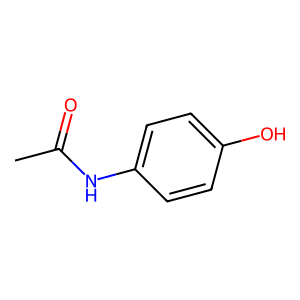

In [7]:


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
example_smiles = Chem.MolFromSmiles('CC(=O)NC1=CC=C(O)C=C1')
Chem.Draw.MolToImage(example_smiles)

...you just got paracetamol'd! rdkit was able to parse the molecule we gave it, so running 'example_smiles' showed us the molecule we asked for. If we supply it with an invalid smiles, though, it would return nothing:

In [8]:
example_smiles = Chem.MolFromSmiles('C=C(=O)C1CCC(O)CC1')
example_smiles == None

[08:24:55] Explicit valence for atom # 1 C, 5, is greater than permitted


True

Now try and do the same with the molecules generated with diffusion, and calculate the percentage of molecules that are parsable with rdkit.
Hints:
 - Remember you're currently cd'd into `contents/DiffSBDD`
 - You can load the sdf file you've generated with `supplier = Chem.SDMolSupplier(path)`
 - Iterate through this list, and for every molecule, check whether it is valid according to rdkit

In [9]:
#how valid are the generated molecules?

There also exist packages that do a slightly more thorough check for molecule plausibility, for example posebusters (documentation [here](https://posebusters.readthedocs.io/en/latest/)). Check through the molecules with this, and see what the most common cause of failure is!

In [10]:

! pip install posebusters --upgrade

In [11]:
! bust ../output_sdfs/3rfm_mol.sdf

../output_sdfs/3rfm_mol.sdf mol_at_pos_0  passes (9 / 9)
../output_sdfs/3rfm_mol.sdf mol_at_pos_1  passes (6 / 9)
Traceback (most recent call last):
  File "/usr/local/bin/bust", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/site-packages/posebusters/cli.py", line 25, in main
    bust(**vars(parser))
  File "/usr/local/lib/python3.10/site-packages/posebusters/cli.py", line 62, in bust
    for i, results_dict in enumerate(posebusters_results):
  File "/usr/local/lib/python3.10/site-packages/posebusters/posebusters.py", line 162, in _run
    module_output = func(**args)
  File "/usr/local/lib/python3.10/site-packages/posebusters/modules/energy_ratio.py", line 78, in check_energy_ratio
    avg_energy = float(get_average_energy(inchi, ensemble_number_conformations))
  File "/usr/local/lib/python3.10/site-packages/posebusters/modules/energy_ratio.py", line 110, in get_average_energy
    energies = new_conformation(mol, n_confs, num_threads)["energies"]
  File "/

Traceback (most recent call last):
  File "/usr/local/bin/bust", line 5, in <module>
    from posebusters.cli import main
  File "/usr/local/lib/python3.10/site-packages/posebusters/__init__.py", line 4, in <module>
    from posebusters.modules.energy_ratio import check_energy_ratio
  File "/usr/local/lib/python3.10/site-packages/posebusters/modules/energy_ratio.py", line 20, in <module>
    from ..tools.molecules import assert_sanity
  File "/usr/local/lib/python3.10/site-packages/posebusters/tools/molecules.py", line 20, in <module>
    from rdkit.Chem.rdMolAlign import GetBestAlignmentTransform
ImportError: cannot import name 'GetBestAlignmentTransform' from 'rdkit.Chem.rdMolAlign' (/usr/local/lib/python3.10/site-packages/rdkit/Chem/rdMolAlign.so)
